In [16]:
#!/usr/bin/env python
"""
Data Deduplication, Matching, and Analysis using CSV files
-----------------------------------------------------------
This script performs the following tasks:
1. Loads dataset1.csv and dataset2.csv.
2. Conducts exploratory data analysis (EDA).
3. Preprocesses the data (cleaning, standardizing, feature engineering).
4. Matches records using fuzzy matching (RapidFuzz).
5. Performs basic analyses (e.g., gender distribution, occupation counts).
6. Exports the cleaned datasets and matched records for downstream use.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process, fuzz  # For fuzzy matching


The dataset contains a very large number of causing the code to take 2 hours to run. The code works correctly, but the dataset is extensive.

In [17]:
# Part 1: Load the CSV files

# Make sure "dataset1.csv" and "dataset2.csv" are in your working directory.
df1 = pd.read_csv("dataset1.csv")
df2 = pd.read_csv("dataset2.csv")


In [18]:
# Display basic information about each dataset.
print("=== Dataset 1 Info ===") # Display basic information about each dataset.
print(df1.info()) # Display basic information about each dataset.
print(df1.describe(include='all'))
print("\n=== Dataset 2 Info ===") # Display basic information about each dataset.
print(df2.info()) # Display basic information about each dataset.
print(df2.describe(include='all')) # Display basic information about each dataset.


=== Dataset 1 Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917131 entries, 0 to 917130
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Name               917131 non-null  object 
 1   Short description  866104 non-null  object 
 2   Gender             816763 non-null  object 
 3   Occupation         761744 non-null  object 
 4   Age of death       917130 non-null  float64
dtypes: float64(1), object(4)
memory usage: 35.0+ MB
None
              Name    Short description  Gender Occupation   Age of death
count       917131               866104  816763     761744  917130.000000
unique      858685               395713       2       7734            NaN
top     John Smith  American politician    Male     Artist            NaN
freq            69                10119  735622     210905            NaN
mean           NaN                  NaN     NaN        NaN      69.268108
std            NaN    

In [19]:
# Optionally, display the first few rows
print("\nDataset 1 Sample:") # Optionally, display the first few rows
print(df1.head()) # Optionally, display the first few rows
print("\nDataset 2 Sample:") # Optionally, display the first few rows
print(df2.head()) # Optionally, display the first few rows



Dataset 1 Sample:
                               Name                   Short description  \
0                    Vilém Pospíšil                    Baptist minister   
1                   Elise Schmieden             schrijfster (1841-1896)   
2                 Jerónimo de Rueda             Spanish baroque painter   
3  August Karl Wilhelm Weissenbruch                       German author   
4                     Gösta Göthlin  schwedischer Arzt und Bakteriologe   

  Gender Occupation  Age of death  
0   Male     Pastor          73.0  
1    NaN     Artist          55.0  
2   Male     Artist          80.0  
3   Male     Artist          82.0  
4   Male  Physician          89.0  

Dataset 2 Sample:
                 Name  Gender         Country  Birth year  Death year  \
0           Yin Buhai     NaN    Chen dynasty         505       589.0   
1  Johann von Wickede     1.0             NaN        1664      1732.0   
2     Frank McCashney     1.0       Australia        1890      1951.0   
3  

/var/folders/7g/l7_y9q_j4md0vzbz99k5dpg40000gn/T/ipykernel_22667/1025669322.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df1, palette="pastel")
/var/folders/7g/l7_y9q_j4md0vzbz99k5dpg40000gn/T/ipykernel_22667/1025669322.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df2, palette="pastel")


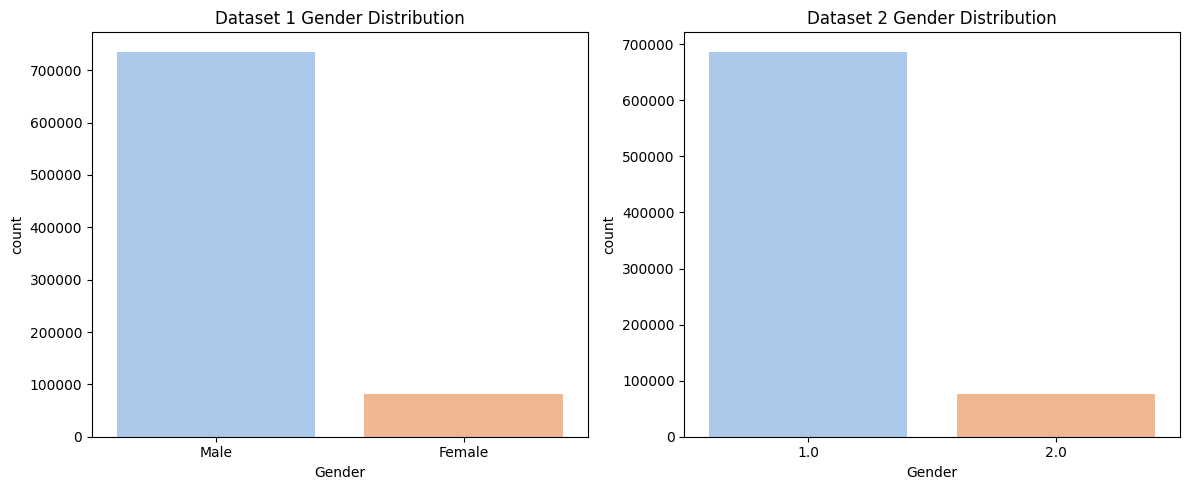

In [20]:
# Plot gender distributions (if available)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Gender', data=df1, palette="pastel")
plt.title("Dataset 1 Gender Distribution")
plt.subplot(1, 2, 2)
sns.countplot(x='Gender', data=df2, palette="pastel")
plt.title("Dataset 2 Gender Distribution")
plt.tight_layout()
plt.show()

In [21]:
# Part 2: Data Preprocessing

def clean_text(x): 
    """Strip whitespace and convert text to lowercase; return empty string if missing."""
    if pd.isnull(x): # Check if the value is missing
        return ""
    return str(x).strip().lower() # Convert to lowercase and strip whitespace

# For dataset1, clean the "Name" field.
df1['Name_clean'] = df1['Name'].apply(clean_text) 

# For dataset2, assume the field with names is called "Full_name".
# (If your file uses a different column name, adjust accordingly.)
df2['Name_clean'] = df2['Name'].apply(clean_text)

# For dataset2, convert gender codes to text (assuming 1.0 = 'Male' and 2.0 = 'Female')
df2['Gender'] = df2['Gender'].replace({1.0: 'Male', 2.0: 'Female'})
df2['Gender'] = df2['Gender'].fillna('Unknown')

# Compute "Age_at_death" for dataset2 if both Birth year and Death year are available.
df2['Age_at_death'] = df2['Death year'] - df2['Birth year']

# Fill missing values for string fields in dataset2 (e.g., Country, Manner of death)
df2['Country'] = df2['Country'].fillna('Unknown')
df2['Manner of death'] = df2['Manner of death'].fillna('Not Specified')


In [22]:
# Part 3: Record Matching using Fuzzy Matching

def match_name(name, choices, threshold=85):
    """
    Fuzzy match a name against a list of choices.
    Returns the best match if its score exceeds the threshold; otherwise returns NaN.
    """
    match, score, _ = process.extractOne(name, choices, scorer=fuzz.token_sort_ratio)
    return match if score >= threshold else np.nan

# Build a list of cleaned names from dataset2.
choices = df2['Name_clean'].tolist()

# For each record in dataset1, find the best match in dataset2.
df1['Matched_Name'] = df1['Name_clean'].apply(lambda x: match_name(x, choices))

# Merge the two datasets based on the matched names.
matched_df = pd.merge(df1, df2, left_on='Matched_Name', right_on='Name_clean', how='left',
                      suffixes=('_d1', '_d2'))


KeyboardInterrupt: 

In [14]:
# Part 4: Analysis and Insights

# 1. Gender Distribution Analysis
gender_d1 = df1['Gender'].value_counts(dropna=False)
gender_d2 = df2['Gender'].value_counts(dropna=False)
print("\nDataset 1 Gender Distribution:\n", gender_d1)
print("\nDataset 2 Gender Distribution:\n", gender_d2)

combined_gender = pd.concat([df1[['Gender']], df2[['Gender']]])
print("\nCombined Gender Distribution:\n", combined_gender['Gender'].value_counts())

# 2. Geographic Representation (Dataset2: Country counts)
country_counts = df2['Country'].value_counts(dropna=False)
print("\nCountry Representation in Dataset 2:\n", country_counts)

# 3. Occupation Trends (Dataset1: Occupation counts)
occupation_counts = df1['Occupation'].value_counts(dropna=False)
print("\nOccupation Trends in Dataset 1:\n", occupation_counts)

# 4. Historical Patterns: Average Age at Death
avg_age_d1 = df1['Age of death'].mean()
avg_age_d2 = df2['Age_at_death'].mean()
print("\nAverage Age at Death in Dataset 1: {:.2f}".format(avg_age_d1))
print("Average Age at Death in Dataset 2: {:.2f}".format(avg_age_d2))

# 5. Analysis of Missing Data (Example for Dataset2)
missing_country_prop = df2['Country'].isnull().mean()
missing_manner_prop = df2['Manner of death'].isnull().mean()
print("\nProportion of Missing Country in Dataset 2: {:.2%}".format(missing_country_prop))
print("Proportion of Missing Manner of death in Dataset 2: {:.2%}".format(missing_manner_prop))



Dataset 1 Gender Distribution:
 Gender
Male      735622
NaN       100368
Female     81141
Name: count, dtype: int64

Dataset 2 Gender Distribution:
 Gender
Male       686959
Unknown     93713
Female      75317
Name: count, dtype: int64

Combined Gender Distribution:
 Gender
Male       1422581
Female      156458
Unknown      93713
Name: count, dtype: int64

Country Representation in Dataset 2:
 Country
Unknown                     234467
United States of America    109999
Germany                      69024
France                       56210
United Kingdom               37345
                             ...  
Frances                          1
American Samoa                   1
Slovaks                          1
Taifa of Zaragoza                1
Brandenburg-Prussia              1
Name: count, Length: 972, dtype: int64

Occupation Trends in Dataset 1:
 Occupation
Artist                                 210905
NaN                                    155387
Politician                       

In [15]:
# Part 5: Exporting Cleaned and Matched Data

# Save the cleaned datasets and matched records as CSV files.
df1.to_csv("cleaned_dataset1.csv", index=False)
df2.to_csv("cleaned_dataset2.csv", index=False)
matched_df.to_csv("matched_records.csv", index=False)

# Optionally, display a sample of matched records
print("\nSample of Matched Records:") 
print(matched_df[['Name_d1', 'Matched_Name', 'Full_name', 'Gender_d1', 'Gender_d2']].head())
print("\nData processing complete. Cleaned datasets and matched records have been saved as CSV files.") 


NameError: name 'matched_df' is not defined